# Human Activity Recognition

The data set contains 561 features which were calculated from time series data from a waist sensor. The data represents 6 possible human activities, walking, walking up stairs, walking down stairs, sitting, standing, and lying (coded as numbers 1-6 respectively).

Loading packages:

In [49]:
library(dplyr)
library(ggplot2)
library(lattice)
library(stringr)
library(gridExtra)
library(caret)
library(rpart)
library(readr)
library(e1071)
options(repos='https://cran.cnr.berkeley.edu/')
install.packages('fastICA')
install.packages('klaR')
install.packages('kknn')
install.packages('gbm')

library(fastICA)
library(klaR)
library(kknn)
library(gbm)

Warning message:
"package 'fastICA' is in use and will not be installed"

package 'klaR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Nolan\AppData\Local\Temp\RtmpgXiLvg\downloaded_packages
package 'kknn' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Nolan\AppData\Local\Temp\RtmpgXiLvg\downloaded_packages
package 'gbm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Nolan\AppData\Local\Temp\RtmpgXiLvg\downloaded_packages


Warning message:
"package 'klaR' was built under R version 3.5.3"Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Warning message:
"package 'kknn' was built under R version 3.5.3"
Attaching package: 'kknn'

The following object is masked from 'package:caret':

    contr.dummy

Warning message:
"package 'gbm' was built under R version 3.5.3"Loaded gbm 2.1.5


### Data Exploration

Loading Data:

In [26]:
X <- read_table('C:/Datasets/UCI HAR Dataset/train/X_train.txt', col_names=FALSE)
y <- read.csv('C:/Datasets/UCI HAR Dataset/train/y_train.txt', header = FALSE)

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


In [27]:
dim(as.matrix(X))
head(X,5)

[1] 7352  561

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X552,X553,X554,X555,X556,X557,X558,X559,X560,X561
0.2885845,-0.02029417,-0.1329051,-0.9952786,-0.9831106,-0.9135264,-0.9951121,-0.9831846,-0.9235270,-0.9347238,...,-0.07432303,-0.2986764,-0.7103041,-0.11275434,0.030400372,-0.4647614,-0.01844588,-0.8412468,0.1799406,-0.05862692
0.2784188,-0.01641057,-0.1235202,-0.9982453,-0.9753002,-0.9603220,-0.9988072,-0.9749144,-0.9576862,-0.9430675,...,0.15807454,-0.5950509,-0.8614993,0.05347695,-0.007434566,-0.7326262,0.70351059,-0.8447876,0.1802889,-0.05431672
0.2796531,-0.01946716,-0.1134617,-0.9953796,-0.9671870,-0.9789440,-0.9965199,-0.9636684,-0.9774686,-0.9386916,...,0.41450281,-0.3907482,-0.7601037,-0.11855926,0.177899480,0.1006992,0.80852908,-0.8489335,0.1806373,-0.04911782
0.2791739,-0.02620065,-0.1232826,-0.9960915,-0.9834027,-0.9906751,-0.9970995,-0.9827498,-0.9893025,-0.9386916,...,0.40457253,-0.1172902,-0.4828445,-0.03678797,-0.012892494,0.6400110,-0.48536645,-0.8486494,0.1819348,-0.04766318
0.2766288,-0.01656965,-0.1153619,-0.9981386,-0.9808173,-0.9904816,-0.9983211,-0.9796719,-0.9904411,-0.9424691,...,0.08775301,-0.3514709,-0.6992052,0.12332005,0.122541960,0.6935783,-0.61597061,-0.8478653,0.1851512,-0.04389225


In [28]:
head(y,5)

V1
5
5
5
5
5


The response vector is an integer vector, which will be converted to a factor.

In [29]:
y[,1] <- factor(y[,1])
summary(y)

 V1      
 1:1226  
 2:1073  
 3: 986  
 4:1286  
 5:1374  
 6:1407  

Check for duplicates and missing values.

In [30]:
sum(duplicated(X))

[1] 0

In [31]:
sum(is.na(X))
sum(is.na(y))

[1] 0

[1] 0

The X matrix and y vector will be combined into a data frame for further processing.

In [32]:
df <- as.data.frame(X)
df$y <- y

Since the features are not readily interpretable, further summarizing of the data will not provide much insight. Instead, the data will be visualized in pairwise plots.

## Data Visualization

Since the data contains so many features, and the features in themselves already are not so easily interpretable, visualization will be performed by first using ICA to extract independent components.

In [47]:
ICA <- preProcess(X,method='ica',n.comp=6)
Xica <- predict(ICA, X)

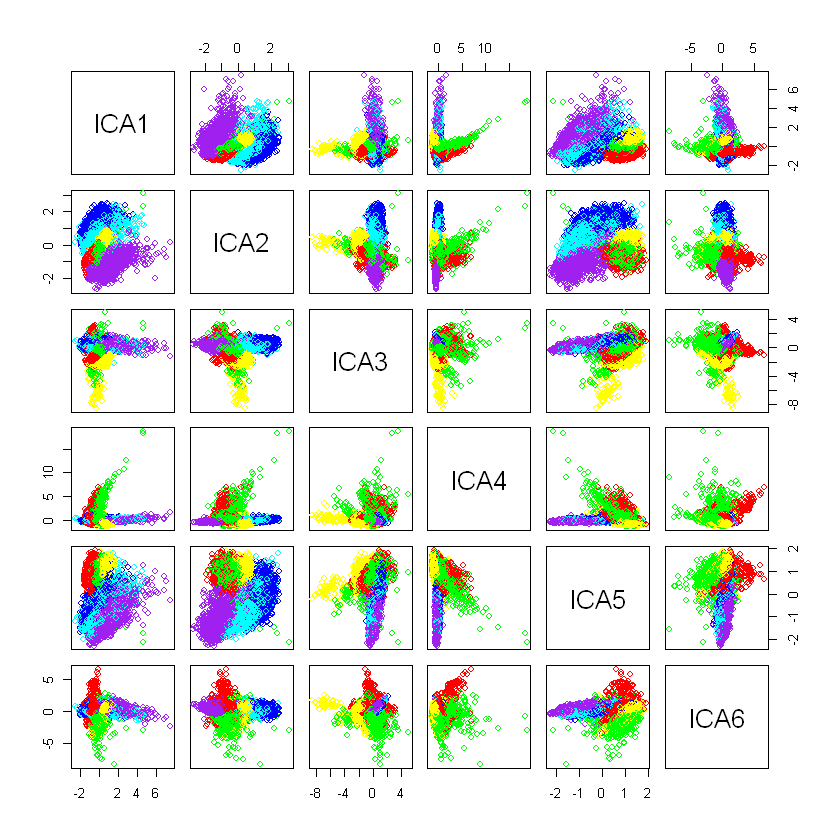

In [48]:
color <- character(7352)
colors <- c('red','yellow','green','cyan','blue','purple')
for(i in 1:6){
    color[y$V1 == paste(i)]<-colors[i]
}
pairs(Xica[,1:6],col=color)

For comparison, a similar plot is generated using PCA.

In [45]:
PCA <- preProcess(X,method='pca')
Xpca <- predict(PCA, X)

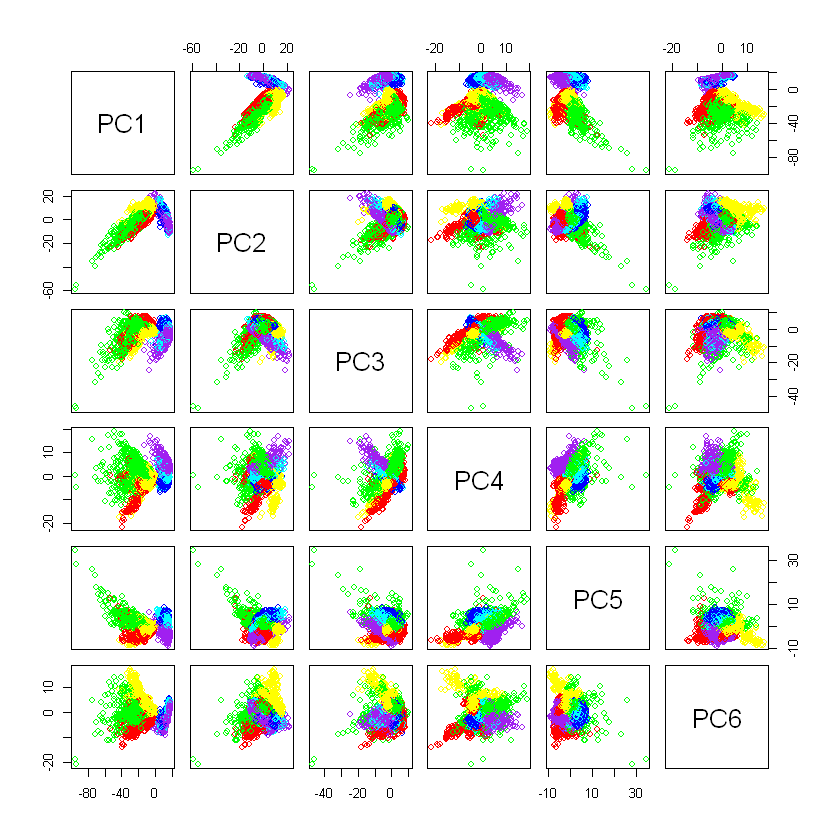

In [46]:
pairs(Xpca[,1:6],col=color)

Under ICA and PCA coordinates, the first three activity levels are sometimes separated from the last three levels. This makes sense because the first three involve walking (straight, up stairs, and down stairs) and the last three are stationary activities (sitting, standing, lying).

Both techniques separate the groups to a small degree, but there is still significant overlap. Modeling will be performed using the full set of predictors if possible.

## Modeling

### Linear Discriminant Analysis

In [52]:
LDAmodel <- train(X, y$V1, method = 'lda',trControl =trainControl(method='repeatedcv',number=5,repeats=3))
LDAmodel

Warning message:
"Setting row names on a tibble is deprecated."Warning message in lda.default(x, grouping, ...):
"variables are collinear"Warning message:
"Setting row names on a tibble is deprecated."Warning message in lda.default(x, grouping, ...):
"variables are collinear"Warning message:
"Setting row names on a tibble is deprecated."Warning message in lda.default(x, grouping, ...):
"variables are collinear"Warning message:
"Setting row names on a tibble is deprecated."Warning message in lda.default(x, grouping, ...):
"variables are collinear"Warning message:
"Setting row names on a tibble is deprecated."Warning message in lda.default(x, grouping, ...):
"variables are collinear"Warning message:
"Setting row names on a tibble is deprecated."Warning message in lda.default(x, grouping, ...):
"variables are collinear"Warning message:
"Setting row names on a tibble is deprecated."Warning message in lda.default(x, grouping, ...):
"variables are collinear"Warning message:
"Setting row name

Linear Discriminant Analysis 

7352 samples
 561 predictor
   6 classes: '1', '2', '3', '4', '5', '6' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 5882, 5881, 5882, 5882, 5881, 5884, ... 
Resampling results:

  Accuracy   Kappa    
  0.9807763  0.9768605


### Logistic Regression

In [54]:
Logisticmodel <- train(X, y$V1, method = 'multinom', MaxNWts = 4000, trControl =trainControl(method='repeatedcv',number=5,repeats=3))
Logisticmodel

Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4657.862717
iter  20 value 1469.346111
iter  30 value 964.551730
iter  40 value 601.231132
iter  50 value 240.204960
iter  60 value 94.408349
iter  70 value 41.713469
iter  80 value 4.568333
iter  90 value 0.111541
iter 100 value 0.010883
final  value 0.010883 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4659.503531
iter  20 value 1482.372145
iter  30 value 1007.594820
iter  40 value 675.822271
iter  50 value 375.613198
iter  60 value 291.820307
iter  70 value 240.931926
iter  80 value 225.072551
iter  90 value 210.636852
iter 100 value 199.967641
final  value 199.967641 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4657.864358
iter  20 value 1469.359200
iter  30 value 964.596980
iter  40 value 601.317701
iter  50 value 240.429646
iter  60 value 94.947027
iter  70 value 43.528168
iter  80 value 14.729617
iter  90 value 12.802585
iter 100 value 11.633487
final  value 11.633487 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10540.920957 
iter  10 value 4649.800471
iter  20 value 1491.600690
iter  30 value 883.916190
iter  40 value 561.598806
iter  50 value 227.488561
iter  60 value 124.413083
iter  70 value 48.575102
iter  80 value 9.643443
iter  90 value 0.314471
iter 100 value 0.023967
final  value 0.023967 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10540.920957 
iter  10 value 4651.415005
iter  20 value 1512.933029
iter  30 value 942.779448
iter  40 value 663.908700
iter  50 value 397.314390
iter  60 value 307.544553
iter  70 value 239.135016
iter  80 value 215.881359
iter  90 value 200.319417
iter 100 value 190.595634
final  value 190.595634 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10540.920957 
iter  10 value 4649.802086
iter  20 value 1491.622152
iter  30 value 883.975484
iter  40 value 561.666370
iter  50 value 227.742042
iter  60 value 125.026093
iter  70 value 49.805833
iter  80 value 12.814925
iter  90 value 10.536275
iter 100 value 9.494198
final  value 9.494198 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10540.920957 
iter  10 value 4440.901926
iter  20 value 1129.461185
iter  30 value 738.104605
iter  40 value 475.763626
iter  50 value 218.657430
iter  60 value 119.134129
iter  70 value 52.814435
iter  80 value 4.231905
iter  90 value 0.208213
iter 100 value 0.009121
final  value 0.009121 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10540.920957 
iter  10 value 4442.387972
iter  20 value 1146.839812
iter  30 value 778.883416
iter  40 value 552.985153
iter  50 value 354.890344
iter  60 value 290.882653
iter  70 value 239.377341
iter  80 value 220.132966
iter  90 value 208.227668
iter 100 value 200.697654
final  value 200.697654 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10540.920957 
iter  10 value 4440.903412
iter  20 value 1129.478655
iter  30 value 738.147126
iter  40 value 475.859272
iter  50 value 218.900240
iter  60 value 119.861931
iter  70 value 55.136984
iter  80 value 15.033026
iter  90 value 13.097739
iter 100 value 11.849604
final  value 11.849604 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 4790.185258
iter  20 value 2036.651150
iter  30 value 1290.083458
iter  40 value 695.811009
iter  50 value 287.523274
iter  60 value 162.545331
iter  70 value 60.715617
iter  80 value 13.530478
iter  90 value 0.308776
iter 100 value 0.017277
final  value 0.017277 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 4791.843802
iter  20 value 2048.722411
iter  30 value 1338.104864
iter  40 value 783.965267
iter  50 value 434.279339
iter  60 value 310.765569
iter  70 value 242.583684
iter  80 value 224.897838
iter  90 value 213.667686
iter 100 value 201.492469
final  value 201.492469 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 4790.186917
iter  20 value 2036.663282
iter  30 value 1290.134263
iter  40 value 695.911854
iter  50 value 287.740604
iter  60 value 162.967243
iter  70 value 61.888112
iter  80 value 18.682617
iter  90 value 13.278835
iter 100 value 11.901388
final  value 11.901388 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4646.930886
iter  20 value 1437.909665
iter  30 value 912.651110
iter  40 value 588.108601
iter  50 value 230.352277
iter  60 value 127.133848
iter  70 value 50.522227
iter  80 value 4.850763
iter  90 value 0.148827
iter 100 value 0.008595
final  value 0.008595 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4648.554199
iter  20 value 1452.786116
iter  30 value 956.567504
iter  40 value 658.555332
iter  50 value 370.422499
iter  60 value 294.539963
iter  70 value 244.725819
iter  80 value 223.178717
iter  90 value 209.245462
iter 100 value 198.333351
final  value 198.333351 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4646.932509
iter  20 value 1437.924591
iter  30 value 912.698952
iter  40 value 588.220333
iter  50 value 230.605912
iter  60 value 127.595080
iter  70 value 53.040726
iter  80 value 13.661824
iter  90 value 11.328724
iter 100 value 10.334408
final  value 10.334408 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10540.920957 
iter  10 value 4445.358644
iter  20 value 1243.971248
iter  30 value 707.753421
iter  40 value 426.965806
iter  50 value 217.768612
iter  60 value 126.589047
iter  70 value 56.248003
iter  80 value 5.075854
iter  90 value 0.081751
iter 100 value 0.006187
final  value 0.006187 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10540.920957 
iter  10 value 4446.989742
iter  20 value 1263.809429
iter  30 value 761.779521
iter  40 value 519.435703
iter  50 value 333.248696
iter  60 value 263.325125
iter  70 value 225.442434
iter  80 value 209.349645
iter  90 value 199.449695
iter 100 value 192.477686
final  value 192.477686 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10540.920957 
iter  10 value 4445.360276
iter  20 value 1243.991246
iter  30 value 707.810904
iter  40 value 427.098866
iter  50 value 217.992361
iter  60 value 127.078965
iter  70 value 57.783913
iter  80 value 17.276416
iter  90 value 14.220929
iter 100 value 12.628382
final  value 12.628382 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 4709.661009
iter  20 value 1482.747238
iter  30 value 947.472505
iter  40 value 628.411000
iter  50 value 241.081873
iter  60 value 108.078811
iter  70 value 42.882146
iter  80 value 4.175343
iter  90 value 0.104530
iter 100 value 0.013020
final  value 0.013020 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 4711.305655
iter  20 value 1508.489924
iter  30 value 998.043329
iter  40 value 703.085300
iter  50 value 384.834984
iter  60 value 305.510481
iter  70 value 252.872304
iter  80 value 234.895858
iter  90 value 219.389482
iter 100 value 209.449637
final  value 209.449637 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 4709.662654
iter  20 value 1482.770812
iter  30 value 947.524592
iter  40 value 628.525058
iter  50 value 241.325373
iter  60 value 108.819856
iter  70 value 45.320154
iter  80 value 17.262734
iter  90 value 14.540289
iter 100 value 13.024966
final  value 13.024966 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4558.169962
iter  20 value 1255.212860
iter  30 value 751.590829
iter  40 value 462.990913
iter  50 value 213.847602
iter  60 value 118.951037
iter  70 value 54.514113
iter  80 value 7.624031
iter  90 value 0.247298
iter 100 value 0.021388
final  value 0.021388 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4560.535144
iter  20 value 1275.047561
iter  30 value 801.415391
iter  40 value 596.161761
iter  50 value 364.353809
iter  60 value 296.653147
iter  70 value 249.654504
iter  80 value 221.228263
iter  90 value 206.337890
iter 100 value 198.681024
final  value 198.681024 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4558.172328
iter  20 value 1255.232817
iter  30 value 751.642933
iter  40 value 463.109720
iter  50 value 214.111267
iter  60 value 119.559935
iter  70 value 55.894835
iter  80 value 15.810722
iter  90 value 12.495594
iter 100 value 11.205017
final  value 11.205017 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10537.337439 
iter  10 value 3541.518467
iter  20 value 2044.077093
iter  30 value 1350.961231
iter  40 value 757.092490
iter  50 value 281.453096
iter  60 value 131.414799
iter  70 value 48.598000
iter  80 value 4.014701
iter  90 value 0.049863
iter 100 value 0.001937
final  value 0.001937 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10537.337439 
iter  10 value 3542.356749
iter  20 value 2051.552746
iter  30 value 1384.825206
iter  40 value 832.609991
iter  50 value 395.626382
iter  60 value 283.277006
iter  70 value 216.086904
iter  80 value 202.110396
iter  90 value 197.220890
iter 100 value 193.461809
final  value 193.461809 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10537.337439 
iter  10 value 3541.519305
iter  20 value 2044.084592
iter  30 value 1350.996539
iter  40 value 757.174110
iter  50 value 281.634728
iter  60 value 131.881994
iter  70 value 49.807854
iter  80 value 12.023607
iter  90 value 10.268779
iter 100 value 9.497774
final  value 9.497774 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 3408.143097
iter  20 value 1266.555453
iter  30 value 931.322001
iter  40 value 608.515896
iter  50 value 226.262323
iter  60 value 79.540671
iter  70 value 23.096912
iter  80 value 0.379430
iter  90 value 0.008957
final  value 0.000092 
converged


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 3409.056940
iter  20 value 1277.269803
iter  30 value 961.849055
iter  40 value 668.248310
iter  50 value 351.110476
iter  60 value 260.940167
iter  70 value 211.043109
iter  80 value 198.927731
iter  90 value 193.290838
iter 100 value 188.867596
final  value 188.867596 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 3408.144011
iter  20 value 1266.566221
iter  30 value 931.353879
iter  40 value 608.587531
iter  50 value 226.490908
iter  60 value 80.455563
iter  70 value 29.030382
iter  80 value 11.230822
iter  90 value 10.390212
iter 100 value 9.526981
final  value 9.526981 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 4698.929113
iter  20 value 1958.324033
iter  30 value 1315.272304
iter  40 value 753.015970
iter  50 value 316.851407
iter  60 value 187.585239
iter  70 value 66.370062
iter  80 value 16.405695
iter  90 value 0.459947
iter 100 value 0.015005
final  value 0.015005 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 4700.555427
iter  20 value 1970.387977
iter  30 value 1361.587305
iter  40 value 833.903330
iter  50 value 481.065607
iter  60 value 312.222776
iter  70 value 245.956304
iter  80 value 222.345360
iter  90 value 209.073695
iter 100 value 198.249548
final  value 198.249548 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10539.129198 
iter  10 value 4698.930740
iter  20 value 1958.336157
iter  30 value 1315.319751
iter  40 value 753.106158
iter  50 value 317.056351
iter  60 value 187.541819
iter  70 value 67.297556
iter  80 value 21.336695
iter  90 value 11.687645
iter 100 value 10.595521
final  value 10.595521 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10537.337439 
iter  10 value 4497.167616
iter  20 value 1157.382415
iter  30 value 712.928230
iter  40 value 500.842956
iter  50 value 227.215850
iter  60 value 122.707895
iter  70 value 47.202547
iter  80 value 4.423029
iter  90 value 0.063319
iter 100 value 0.005040
final  value 0.005040 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10537.337439 
iter  10 value 4498.650377
iter  20 value 1174.698197
iter  30 value 758.728998
iter  40 value 551.470495
iter  50 value 349.867770
iter  60 value 285.811773
iter  70 value 233.625206
iter  80 value 215.287132
iter  90 value 202.745022
iter 100 value 194.396546
final  value 194.396546 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10537.337439 
iter  10 value 4497.169099
iter  20 value 1157.399830
iter  30 value 712.976311
iter  40 value 500.930458
iter  50 value 227.434403
iter  60 value 123.396526
iter  70 value 49.071778
iter  80 value 14.965389
iter  90 value 13.000149
iter 100 value 11.713985
final  value 11.713985 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10542.712717 
iter  10 value 4624.542175
iter  20 value 1438.548262
iter  30 value 935.155918
iter  40 value 612.972013
iter  50 value 239.548800
iter  60 value 102.012179
iter  70 value 51.127941
iter  80 value 8.768831
iter  90 value 0.301598
iter 100 value 0.022805
final  value 0.022805 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10542.712717 
iter  10 value 4626.159118
iter  20 value 1458.300360
iter  30 value 985.173710
iter  40 value 681.032497
iter  50 value 385.652803
iter  60 value 302.159139
iter  70 value 251.526298
iter  80 value 230.049961
iter  90 value 215.362179
iter 100 value 202.324995
final  value 202.324995 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10542.712717 
iter  10 value 4624.543792
iter  20 value 1438.568125
iter  30 value 935.208234
iter  40 value 613.067427
iter  50 value 239.788960
iter  60 value 102.753679
iter  70 value 52.942207
iter  80 value 19.335697
iter  90 value 15.144895
iter 100 value 13.364719
final  value 13.364719 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4673.349786
iter  20 value 1547.766817
iter  30 value 1011.340057
iter  40 value 663.273185
iter  50 value 267.108806
iter  60 value 124.167625
iter  70 value 40.435049
iter  80 value 3.586583
iter  90 value 0.111348
iter 100 value 0.009467
final  value 0.009467 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4675.009787
iter  20 value 1560.400171
iter  30 value 1055.612721
iter  40 value 716.634428
iter  50 value 412.145793
iter  60 value 306.884471
iter  70 value 250.125567
iter  80 value 225.972908
iter  90 value 212.164701
iter 100 value 200.125650
final  value 200.125650 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10535.545679 
iter  10 value 4673.351446
iter  20 value 1547.779511
iter  30 value 1011.387241
iter  40 value 663.373245
iter  50 value 267.315705
iter  60 value 124.668806
iter  70 value 42.073026
iter  80 value 12.584375
iter  90 value 10.853848
iter 100 value 9.945508
final  value 9.945508 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10537.337439 
iter  10 value 4675.484105
iter  20 value 1513.919574
iter  30 value 865.401395
iter  40 value 571.941194
iter  50 value 253.767463
iter  60 value 139.992217
iter  70 value 62.345090
iter  80 value 18.773274
iter  90 value 0.916021
iter 100 value 0.045718
final  value 0.045718 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10537.337439 
iter  10 value 4677.082198
iter  20 value 1535.633733
iter  30 value 924.724254
iter  40 value 665.864392
iter  50 value 387.549779
iter  60 value 313.112736
iter  70 value 254.605234
iter  80 value 230.734452
iter  90 value 218.328992
iter 100 value 204.932954
final  value 204.932954 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 10537.337439 
iter  10 value 4675.485704
iter  20 value 1513.941407
iter  30 value 865.463950
iter  40 value 572.025109
iter  50 value 253.984194
iter  60 value 140.341362
iter  70 value 63.382067
iter  80 value 23.069655
iter  90 value 16.444927
iter 100 value 14.462053
final  value 14.462053 
stopped after 100 iterations


Warning message:
"Setting row names on a tibble is deprecated."

# weights:  3378 (2810 variable)
initial  value 13173.015618 
iter  10 value 3214.445929
iter  20 value 1644.151293
iter  30 value 1277.817851
iter  40 value 877.852196
iter  50 value 489.412738
iter  60 value 346.385743
iter  70 value 281.041631
iter  80 value 256.994166
iter  90 value 247.450292
iter 100 value 240.623582
final  value 240.623582 
stopped after 100 iterations


Penalized Multinomial Regression 

7352 samples
 561 predictor
   6 classes: '1', '2', '3', '4', '5', '6' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 5880, 5883, 5883, 5882, 5880, 5883, ... 
Resampling results across tuning parameters:

  decay  Accuracy   Kappa    
  0e+00  0.9473618  0.9366134
  1e-04  0.9728876  0.9673573
  1e-01  0.9844500  0.9812820

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was decay = 0.1.

### Support Vector Machine

SVM and kNN need scaled features.

In [55]:
scaling <- preProcess(X, method='scale')
scaledX <- predict(scaling, X)

In [56]:
SVMLinmodel <- train(scaledX, y$V1, method = 'svmLinear', trControl =trainControl(method='repeatedcv',number=5,repeats=3))
SVMLinmodel

Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is depr

Support Vector Machines with Linear Kernel 

7352 samples
 561 predictor
   6 classes: '1', '2', '3', '4', '5', '6' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 5882, 5881, 5882, 5881, 5882, 5882, ... 
Resampling results:

  Accuracy   Kappa   
  0.9828163  0.979316

Tuning parameter 'C' was held constant at a value of 1

In [57]:
SVMRadmodel <- train(scaledX, y$V1, method = 'svmRadial', trControl =trainControl(method='repeatedcv',number=5,repeats=3))
SVMRadmodel

Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is depr

Support Vector Machines with Radial Basis Function Kernel 

7352 samples
 561 predictor
   6 classes: '1', '2', '3', '4', '5', '6' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 5882, 5882, 5881, 5882, 5881, 5882, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.9584704  0.9500229
  0.50  0.9721173  0.9664414
  1.00  0.9778298  0.9733157

Tuning parameter 'sigma' was held constant at a value of 0.001997289
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.001997289 and C = 1.

### k Nearest Neighbors

In [60]:
kNNmodel <- train(scaledX, y$V1, method = 'knn', trControl =trainControl(method='repeatedcv',number=5,repeats=3))
kNNmodel

Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is depr

k-Nearest Neighbors 

7352 samples
 561 predictor
   6 classes: '1', '2', '3', '4', '5', '6' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 5881, 5882, 5883, 5881, 5881, 5883, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.9609630  0.9529978
  7  0.9568827  0.9480809
  9  0.9555670  0.9464954

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.

### Naive Bayes

In [61]:
NBmodel <- train(X, y$V1, method = 'nb',trControl =trainControl(method='repeatedcv',number=5,repeats=3))
NBmodel

Warning message:
"Setting row names on a tibble is deprecated."Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 99"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 127"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 208"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 209"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 214"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 239"Warning message in FUN(X[[i]], ...):
"Numerical 0 pro

Naive Bayes 

7352 samples
 561 predictor
   6 classes: '1', '2', '3', '4', '5', '6' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 5881, 5882, 5881, 5883, 5881, 5882, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa    
  FALSE      0.7209910  0.6653259
   TRUE      0.7704948  0.7242201

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were fL = 0, usekernel = TRUE and adjust
 = 1.

### Decision Tree

In [62]:
Treemodel <- train(X, y$V1, method = 'rpart',trControl =trainControl(method='repeatedcv',number=5,repeats=3))
Treemodel

Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is depr

CART 

7352 samples
 561 predictor
   6 classes: '1', '2', '3', '4', '5', '6' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 5882, 5883, 5882, 5880, 5881, 5882, ... 
Resampling results across tuning parameters:

  cp         Accuracy   Kappa    
  0.1663583  0.6133321  0.5297484
  0.2062237  0.4557399  0.3328328
  0.2311186  0.2784373  0.1093237

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.1663583.

In [64]:
Grid = expand.grid(cp=c(0.0001, 0.001, 0.01, 0.1))
Treemodel <- train(X, y$V1, method = 'rpart',trControl =trainControl(method='repeatedcv',number=5,repeats=3),tuneGrid = Grid)
Treemodel

Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is depr

CART 

7352 samples
 561 predictor
   6 classes: '1', '2', '3', '4', '5', '6' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 5881, 5881, 5883, 5881, 5882, 5883, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  1e-04  0.9402862  0.9281200
  1e-03  0.9395601  0.9272425
  1e-02  0.8884664  0.8657260
  1e-01  0.8820278  0.8579325

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 1e-04.

In [66]:
Grid = expand.grid(cp=c(0.000001, 0.00001, 0.0001))
Treemodel <- train(X, y$V1, method = 'rpart',trControl =trainControl(method='repeatedcv',number=5,repeats=3),tuneGrid = Grid)
Treemodel

Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is depr

CART 

7352 samples
 561 predictor
   6 classes: '1', '2', '3', '4', '5', '6' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 5882, 5882, 5883, 5880, 5881, 5881, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  1e-06  0.9391547  0.9267585
  1e-05  0.9391547  0.9267585
  1e-04  0.9396533  0.9273593

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 1e-04.

### Random Forest

In [71]:
RFmodel <- train(X, y$V1, method = 'rf',trControl =trainControl(method='repeatedcv',number=5,repeats=3))
RFmodel

Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is depr

Random Forest 

7352 samples
 561 predictor
   6 classes: '1', '2', '3', '4', '5', '6' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 5881, 5883, 5881, 5882, 5881, 5882, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
    2   0.9670848  0.9603772
   33   0.9797345  0.9756063
  561   0.9693515  0.9631070

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 33.

All the models that involve hyperplanes of separation perform better in cross validation than models that do not assume linear decision boundaries. This is probably due to the large number of features, which causes overfitting in those models. The models with hyplerplanes of separation have high accuracy in cross validation, which indicate minimal overfitting even with the large number of features. LDA, linear SVM, and logistic regression have similar cross validation accuracy, but LDA is faster. Therefore LDA will be chosen as the final model.

In [74]:
Xtest <- read_table('C:/Datasets/UCI HAR Dataset/test/X_test.txt', col_names=FALSE)
ytest <- read.csv('C:/Datasets/UCI HAR Dataset/test/y_test.txt', header = FALSE)
ytest[,1] <- factor(ytest[,1])
dftest <- as.data.frame(Xtest)
dftest$y <- ytest

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


In [78]:
ypred <- factor(predict(LDAmodel,Xtest))
confusionMatrix(ypred,ytest[,1])

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4   5   6
         1 490  11   1   0   0   0
         2   6 460  14   1   0   0
         3   0   0 405   0   0   0
         4   0   0   0 434  22   0
         5   0   0   0  56 510   0
         6   0   0   0   0   0 537

Overall Statistics
                                          
               Accuracy : 0.9623          
                 95% CI : (0.9548, 0.9689)
    No Information Rate : 0.1822          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9547          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity            0.9879   0.9766   0.9643   0.8839   0.9586   1.0000
Specificity            0.9951   0.9915   1.0000   0.9910   0.9768   1.0000
Pos Pred Value         0.9761   0.9563   1.0000   0.9518   0.9011   1.0000
Neg Pred Value 

The LDA model is fairly accurate. Most of the confusion is between walking/walking upstairs/wallking downstairs and between standing and sitting. This is understandable because walking is similar to walking on stairs and because the orientation of the waist is similar when standing and sitting.